In [4]:
!pip install pandas_ta

In [5]:
#disable warnings
import warnings
warnings.filterwarnings('ignore')
#common
import os
import traceback
from datetime import datetime
import random
import json
from tqdm import tqdm
import numpy as np
import pandas as pd
import pandas_ta as ta
import datetime as dt
from datetime import datetime
import psycopg2 as db
import scipy.stats
import plotly.graph_objects as go
import seaborn as sns

ĐỌC VÀ TIỀN XỬ LÝ DỮ LIỆU ĐẦU VÀO

In [6]:
# edit by Cuong
class StringConverter(dict):
    def __contains__(self, item):
        return True

    def __getitem__(self, item):
        return str

    def get(self, default=None):
        return str

In [7]:
# Reading users' Bank Account, Credit Card, Device and Orders data from csv
bank_df  = pd.read_csv('/content/drive/Othercomputers/My Laptop/Shopee/fraud_shopee/bank_accounts.csv', converters=StringConverter())
credit_df  = pd.read_csv('/content/drive/Othercomputers/My Laptop/Shopee/fraud_shopee/credit_cards.csv', converters=StringConverter())
devices_df = pd.read_csv('/content/drive/Othercomputers/My Laptop/Shopee/fraud_shopee/devices.csv', converters=StringConverter())
orders_df  = pd.read_csv('/content/drive/Othercomputers/My Laptop/Shopee/fraud_shopee/orders.csv', converters=StringConverter())
# chuyển dạng string cho userid trong đơn
orders_df['buyer_code']=orders_df['buyer_userid'].astype(str)
orders_df['seller_code']=orders_df['seller_userid'].astype(str)

In [8]:
# edit by Cuong
# Xóa trùng lặp trong bảng
bank_df = bank_df.drop_duplicates()
credit_df = credit_df.drop_duplicates()
devices_df = devices_df.drop_duplicates()
orders_df = orders_df.drop_duplicates()

In [9]:
# Lấy tập user chung device, creditcard, bank_account
df_user_device = devices_df.groupby('device').filter(lambda x: len(x) > 1)
df_user_creditcard = credit_df.groupby('credit_card').filter(lambda x: len(x) > 1)
df_user_account = bank_df.groupby('bank_account').filter(lambda x: len(x) > 1)

df_user_device = df_user_device.rename(columns={"device": "refitem"})
df_user_creditcard = df_user_creditcard.rename(columns={"credit_card": "refitem"})
df_user_account = df_user_account.rename(columns={"bank_account": "refitem"})
df_user_device['type']='device'
df_user_creditcard['type']='creditcard'
df_user_account['type']='account'

df_user_device=df_user_device.reset_index(drop=True)
df_user_creditcard=df_user_creditcard.reset_index(drop=True)
df_user_account=df_user_account.reset_index(drop=True)

# Merge userset
frames = [df_user_device, df_user_creditcard, df_user_account]
df_user_relation = pd.concat(frames).reset_index(drop=True) #User relation
df_user_relation['device'] = df_user_relation.apply(lambda x: 1 if x.type == 'device' else 0, axis=1)
df_user_relation['account'] = df_user_relation.apply(lambda x: 1 if x.type == 'account' else 0, axis=1)
df_user_relation['creditcard'] = df_user_relation.apply(lambda x: 1 if x.type == 'creditcard' else 0, axis=1)

In [10]:
# Xuất file ra csv
df_user_relation.to_csv('/content/drive/Othercomputers/My Laptop/Shopee/user_relation.csv', index=False)

In [11]:
# Community Dectection: Chung device/account/creditcard
#-------------------------------------------------------------

# Build userset
df_userset = df_user_relation.copy()
# chuyển về dữ liệu dạng chuỗi để build thành xâu ký các ID
df_userset['usercode']=df_userset['userid'].astype(str)
df_userset['refitem'] = df_userset['refitem'].str.strip()

# Chuỗi user có cùng refitem, type: cùng device, account, credit_card
df_user_link = df_userset.groupby(['refitem', 'type'], as_index=False).agg({'usercode': ','.join})
df_user_link = df_user_link.rename(columns={"usercode": "userset"})

# Node from user
arr_node_usercode = df_userset['usercode'].unique()

# Edge từ cạnh là device, account, card
dic_weight = {'device':1, 'account':1, 'creditcard':1}
dic_node_edge = {}
for index, row in df_user_link.iterrows():
    val_edgeid = row['refitem']
    val_edgetype = row['type']
    arr_userset = row['userset'].split(',')
    # Thiết lập cạnh đôi một
    list_of_pairs = [(p1, p2) for p1 in arr_userset for p2 in arr_userset \
                      if p1 != p2]
    for item in list_of_pairs:
        # Phép giao hoán nodeA -> nodeB, nodeB -> nodeA là như nhau
        val_edge_1 = item[0] + ',' + item[1]
        val_edge_2 = item[1] + ',' + item[0]
        # Tính toán trọng số của cạnh
        if (dic_node_edge.get(val_edge_1)==None) \
            and (dic_node_edge.get(val_edge_2)==None):
            dic_node_edge[val_edge_1] = dic_weight[val_edgetype]
        else:
            if (dic_node_edge.get(val_edge_1)!=None):
                val_edge_current=dic_node_edge[val_edge_1]
                dic_node_edge[val_edge_1] = val_edge_current+dic_weight[val_edgetype]
            else:
                val_edge_current=dic_node_edge[val_edge_2]
                dic_node_edge[val_edge_2] = val_edge_current+dic_weight[val_edgetype]

df_node_edge = pd.DataFrame.from_dict(dic_node_edge, orient='index').reset_index()
df_node_edge.rename(columns={'index': 'pair', 0: 'edge'}, inplace=True)
df_node_edge[['A', 'B']] = df_node_edge['pair'].str.split(',', 1, expand=True)

In [12]:
df_node_edge.sort_values(by=['edge'], ascending=False)

,pair,edge,A,B
1284,"8802740,33152428",142,8802740,33152428
482,"54011648,59199762",92,54011648,59199762
3061,"37757776,18267376",64,37757776,18267376
13735,"10054962,10640710",64,10054962,10640710
832,"11091848,2486882",62,11091848,2486882
...,...,...,...,...
27124,"151550652,37623620",2,151550652,37623620
27125,"53934156,37623620",2,53934156,37623620
27126,"36187588,23963662",2,36187588,23963662
27128,"165287512,57332008",2,165287512,57332008


ĐƠN HÀNG CÓ BUYER/SELLER TRỰC TIẾP

In [13]:
# Tập user có mối quan hệ trực tiếp
df_user_set_direct = df_node_edge.groupby(['A'], as_index=False).agg({'B': ','.join})
df_user_set_direct = df_user_set_direct.rename(columns={"A": "usercode", "B": "userset"})

# Các đơn hàng có tập buyer/seller cần quan tâm
# buyer = usercode, seller xuất hiện trong tập userset
df_buyer_order = orders_df.merge(df_user_set_direct, left_on=['buyer_code'], right_on = ['usercode'], how='inner')
df_buyer_order['tag_direct'] = df_buyer_order.apply(lambda x: True if x.seller_code in x.userset else False, axis=1)

In [14]:
# Cặp user trực tiếp có gian lận
df_user_order_direct = df_buyer_order[df_buyer_order['tag_direct']==True]
df_user_order_direct = df_user_order_direct.groupby(['buyer_code', 'seller_code'], \
                                  as_index=False).agg({'orderid': 'count'}).sort_values(by=['orderid'], ascending=False)
df_user_order_direct

,buyer_code,seller_code,orderid
24,155985518,133103872,26
86,235452908,235460800,8
27,159132118,187392042,6
0,100918044,68742042,4
58,216535812,235585144,3
...,...,...,...
36,179270308,39018130,1
35,175581274,123961640,1
34,174740780,118892656,1
33,172659926,53976872,1


ĐƠN HÀNG CÓ BUYER/SELLER GIÁN TIẾP

Tần suất xuất hiện order giữa 02 user trong order = count(orderid),
Tìm đường đi giữa hai user có đơn hàng,
Đường càng ngắn mối quan hệ càng gần,
Số lượng đường đi giữa 02 user,
degree bậc của một user, phân cụm user

In [15]:
# User Graph
import matplotlib.pyplot as plt
import networkx as nx
users_graph = nx.Graph()
# Tạo đồ thị với  usercode là node
# 'usercode' có cùng 'bank_account', 'credit_card' or 'device'
users_graph.add_nodes_from(arr_node_usercode)
# Tạo cạnh giữa các node
for key, value in dic_node_edge.items():
    nodes = key.split(',')
    users_graph.add_edges_from([(nodes[0], nodes[1])], weight=value)

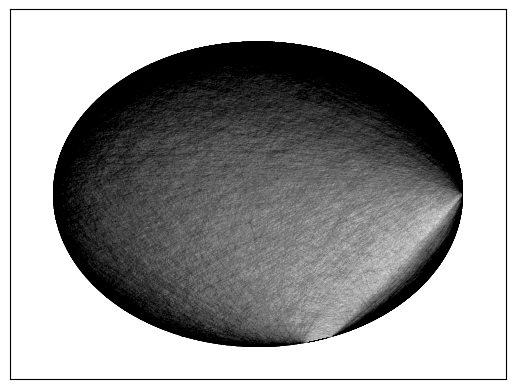

In [16]:
# Graph visulization
pos = nx.circular_layout(users_graph)
nx.draw_networkx_edges(users_graph, pos, width=0.01, alpha=0.5)


In [17]:
# Hàm kiểm tra tồn tại đường đi giữa 02 node
def is_node_edge(G, buyer_id, seller_id):
    """
    Function to detect frauds by checking if there exists a path
    from buyer_id node to seller_id node in users_graph.
    """
    # Check if both buyer_id and seller_id are in users_graph
    if G.has_node(buyer_id) and G.has_node(seller_id):
        # Check if there is a path from buyer_id to seller_id
        if buyer_id in nx.algorithms.descendants(G, seller_id):
            return 1
    return 0

In [18]:
# Danh sách các cặp user có đơn hàng
df_user_order = orders_df.groupby(['buyer_code', 'seller_code'], \
                                  as_index=False).agg({'orderid': 'count'}).sort_values(by=['orderid'], ascending=False)

In [19]:
# Xác định có đường đi giữa 02 node không
df_user_order['has_path'] = \
    df_user_order.apply(lambda row: is_node_edge(users_graph, row.buyer_code, row.seller_code), axis=1)

In [20]:
# Các cặp user cần quan tâm: Có đường đi giữa 02 node
df_user_order_indirect = df_user_order[df_user_order['has_path']==1][['buyer_code','seller_code','orderid']]
df_user_order_indirect

,buyer_code,seller_code,orderid
140309,155985518,133103872,26
289828,224296274,193350172,13
296331,227124616,15459944,11
323908,234217326,39287026,10
335855,235452908,235460800,8
...,...,...,...
194962,18029254,18745828,1
187973,176873634,62533600,1
186102,17621842,39287026,1
201345,18318374,10797932,1


In [21]:
# Cặp user indirect không có trong direct
df_user_gap=pd.concat([df_user_order_indirect, df_user_order_direct]).drop_duplicates(keep=False)
df_user_gap

,buyer_code,seller_code,orderid
289828,224296274,193350172,13
296331,227124616,15459944,11
323908,234217326,39287026,10
335974,235457118,235460800,8
287705,223406364,193350172,7
...,...,...,...
190907,178244640,129295230,1
194962,18029254,18745828,1
187973,176873634,62533600,1
186102,17621842,39287026,1


PHÂN CỤM NHÓM CÁC USER LIÊN QUAN ĐẾN NHAU